# Set global parameters


The OptimUS library provides functionality to simulate acoustic wave propagation in unbounded domains with homogeneous scatterers. This notebook demonstrates how to set global parameters of the library.


## Import the OptimUS library

Load the OptimUS library.

In [1]:
# Make sure the OptimUS library is in the Python path.
import sys
sys.path.append('..')

In [2]:
import optimus

## View global parameters

The OptimUS library uses default settings in a variety of routines. The global parameters can be viewed and changed in the ```optimus.global_parameters``` class instance.

In [3]:
optimus.global_parameters.print()


Verbosity parameter: False

Linear algebra parameters:
 Linear solver: gmres
 Tolerance: 1e-05
 Maximum number of iterations: 1000
 Number of iterations before restart: 1000

Incident field parameters:
 Number of CPU used in parallelisation: 64
 Memory allocation per core: 20000000 bytes
 Parallelisation method: multiprocessing

Preconditioning parameters:
 OSRC preconditioner.
  Number of Padé expansion terms: 4
  Branch cut angle for Padé series: 1.0471975511965976
  Wavenumber: int
  Damped wavenumber: None

Postprocessing parameters:
 Potential operator assembly type is:  dense
 Solid angle tolerance is:  0.1


Additionally, the global parameters of the BEMPP library (which is heavily used by OptimUS), can be retrieved as ```optimus.global_parameters.bempp_parameters```.

In [4]:
print("The assembly type used by BEMPP is:",
      optimus.global_parameters.bempp_parameters.assembly.boundary_operator_assembly_type)

The assembly type used by BEMPP is: hmat


For example, the assembly type for the discrete operators can be set to a dense mode, which is more accurate but computationally more expensive.

In [5]:
optimus.global_parameters.bempp_parameters.assembly.boundary_operator_assembly_type = "dense"
print("The assembly type used by BEMPP is:",
      optimus.global_parameters.bempp_parameters.assembly.boundary_operator_assembly_type)

The assembly type used by BEMPP is: dense


## Specify the wave model

Let us consider a standard test case of a spherical bone embedded in water, excited by a plane wave, and solved by a standard BEM model.

In [6]:
source = optimus.source.create_planewave(frequency=1000)
geometry = optimus.geometry.shapes.Sphere(element_size=0.4)
material_ext = optimus.material.load_material('water')
material_int = optimus.material.load_material('bone (cortical)')

In [7]:
model = optimus.model.create_acoustic_model(source, geometry, material_ext, material_int)

## Simulate the wave model with different global parameters for the linear solver

The BEM model is solved with the GMRES algorithm. As an iterative linear solver, one can specify the tolerance and the maximum number of iterations. Let us solve the model with the default settings and then change them.

In [8]:
model.solve()

In [9]:
print("The global parameters for the linear algebra are as follows.\n")
optimus.global_parameters.linalg.print()
print("\nThe model was solved in", model.iteration_count, "iterations.")

The global parameters for the linear algebra are as follows.

Linear solver: gmres
Tolerance: 1e-05
Maximum number of iterations: 1000
Number of iterations before restart: 1000

The model was solved in 25 iterations.


Let us change the tolerance of the GMRES algorithm. Generally speaking, a smaller tolerance gives a more accurate approximation to the surface potentials but requires more iterations from the linear solver.

In [10]:
optimus.global_parameters.linalg.tol = 1e-9

In [11]:
model.solve()

In [12]:
print("The global parameters for the linear algebra are as follows.\n")
optimus.global_parameters.linalg.print()
print("\nThe model was solved in", model.iteration_count, "iterations.")

The global parameters for the linear algebra are as follows.

Linear solver: gmres
Tolerance: 1e-09
Maximum number of iterations: 1000
Number of iterations before restart: 1000

The model was solved in 37 iterations.


Let us change the maximum number of iterations that can be used by GMRES. A smaller value limits the simulation time of the linear solver. However, if this maximum is reached, the solution might not be accurate since the final estimate has a larger residual than the specified tolerance.

In [13]:
optimus.global_parameters.linalg.maxiter = 10

In [14]:
model.solve()

../optimus/model/linalg.py:93: RuntimeWarning: The GMRES solver stopped at the maximum number of 10 iterations.
  RuntimeWarning,


In [15]:
print("The global parameters for the linear algebra are as follows.\n")
optimus.global_parameters.linalg.print()
print("\nThe model was solved in", model.iteration_count, "iterations.")

The global parameters for the linear algebra are as follows.

Linear solver: gmres
Tolerance: 1e-09
Maximum number of iterations: 10
Number of iterations before restart: 1000

The model was solved in 10 iterations.


## Visualisation of the acoustic field

The acoustic field can be calculated in arbitrary points. Let us visualize the field on a grid in the plane $z=0$.

In [16]:
postprocess_plane = optimus.postprocess.VisualisePlane(model)
postprocess_plane.create_computational_grid(bounding_box=[-3, 4, -3, 3])
postprocess_plane.compute_fields()

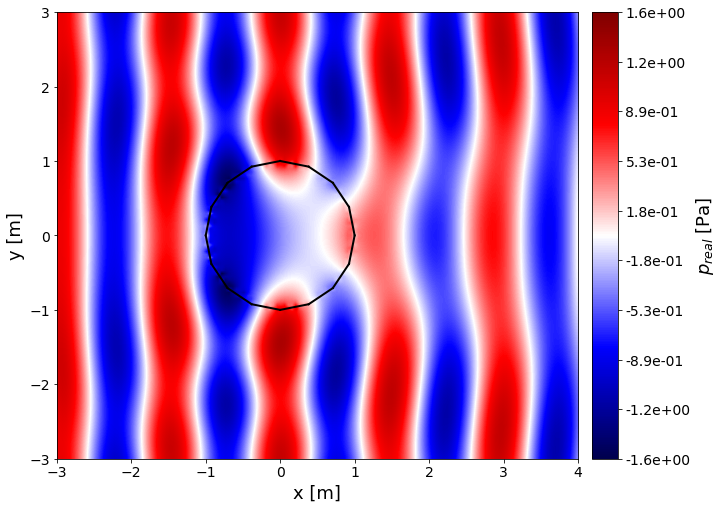

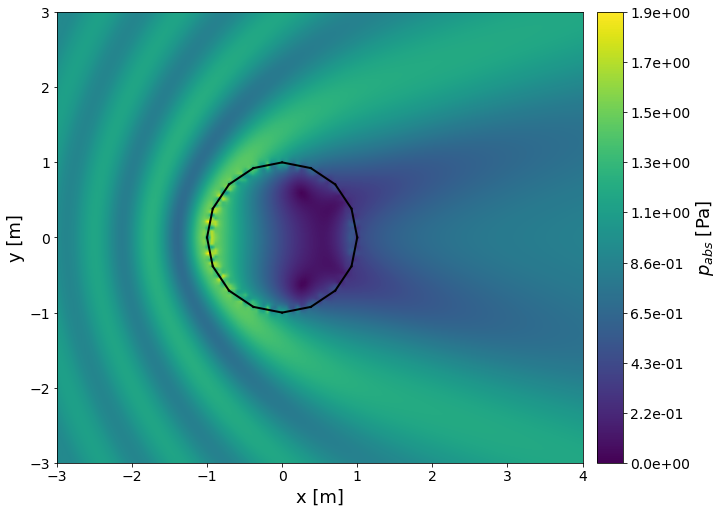

In [17]:
%matplotlib inline
figs = optimus.postprocess.plot_pressure_field(postprocess_plane)